### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [2]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [2]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [3]:
CHECKPOINT_PATH = os.path.join(os.getcwd(), "weights", "sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [4]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=1.00,
    stability_score_thresh=0.98,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
)

In [7]:
file_name = 'tshirt_0001.jpg'

img_path = get_training_data_path(file_name)
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image_rgb)

In [11]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

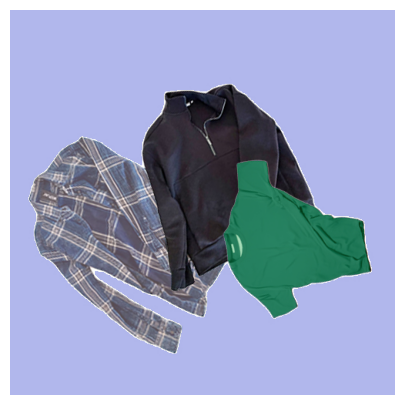

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(image_rgb)
show_anns(masks)
plt.axis('off')
plt.show() 

TypeError: Image data of dtype object cannot be converted to float

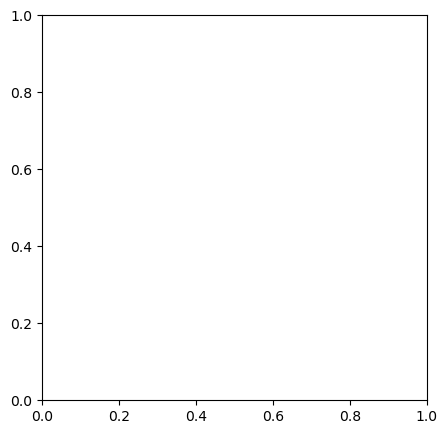

In [15]:
len(masks)
plt.figure(figsize=(5,5))
plt.imshow(masks[0])